In [44]:
import time
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from datetime import datetime, timedelta
import praw
import prawcore
import torch
import os
from dotenv import load_dotenv
from getpass import getpass


load_dotenv()


# Enable MPS fallback for operations not supported on the GPU
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Select device: use MPS (Metal Performance Shaders) if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

Using device: mps


In [45]:
# Try to get credentials from environment variables
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")
username = os.getenv("REDDIT_USERNAME")
password = os.getenv("REDDIT_PASSWORD")

# If any credential is missing, prompt for input
if not client_id:
    client_id = getpass("Enter your Reddit Client ID: ")
if not client_secret:
    client_secret_input = getpass("Enter your Reddit Client Secret: ")
    client_secret = None if client_secret_input.strip() == "" else client_secret_input
if not username:
    username = getpass("Enter your Reddit username: ")
if not password:
    password = getpass("Enter your Reddit password: ")

user_agent = "Stock prediction by /u/Stoic_Gaze"

# Create Reddit instance with error handling
try:
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        username=username,
        password=password,
        user_agent=user_agent
    )
    print("Logged in as:", reddit.user.me())
except Exception as e:
    print(f"Failed to initialize Reddit API: {e}")
    print("Please check your credentials and try again.")

Logged in as: StoicGaze


In [46]:
def clean_text(text):
    """
    Clean text by removing user mentions, emojis, and common stopwords
    """
    if not isinstance(text, str):  # Check if text is a string
        return ""
    
    # Remove user mentions (e.g. u/username)
    text = re.sub(r'/?u/\w+', '', text)
    
    # Remove emojis - simple approach to remove most common emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    return text

def check_stock_mentions(text, target_stocks):
    """
    Check if text contains mentions of target stocks
    Returns: (has_mention, tickers_)
    """
    if not isinstance(text, str):  # Check if text is a string
        return 0, []
    
    # Define patterns for stock mentions
    # Match both $TICKER and just TICKER
    tickers_ = []
    
    for ticker in target_stocks:
        # Remove $ if present for comparison
        clean_ticker = ticker.replace('$', '')
        
        # Check for ticker with or without $ prefix
        pattern = r'(\$' + clean_ticker + r'\b|\b' + clean_ticker + r'\b)'
        if re.search(pattern, text, re.IGNORECASE):
            tickers_.append(clean_ticker)
    
    has_mention = 1 if tickers_ else 0
    return has_mention, tickers_

def remove_stopwords(text):
    """
    Remove common stopwords from text
    """
    if not isinstance(text, str):  # Check if text is a string
        return ""
    
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [47]:
def redditScrape(reddit, subredditName, start_date, end_date, target_stocks=['TSLA', 'GME', 'AAPL', 'NVDA'], post_limit=1000):
    """
    Scrape Reddit posts with stock-specific enhancements
    
    Parameters:
    - reddit: Reddit API instance
    - subredditName: Subreddit to scrape
    - start_date: Datetime object for starting date
    - end_date: Datetime object for ending date
    - target_stocks: List of stock tickers to specifically track
    - post_limit: Maximum number of posts to retrieve
    
    Returns:
    - DataFrame with Reddit posts and stock-specific data
    """
    subreddit = reddit.subreddit(subredditName)
    posts = []
    
    # Normalize target_stocks to ensure consistent processing
    target_stocks = [ticker.replace('$', '').upper() for ticker in target_stocks]
    
    try:
        for post in subreddit.new(limit=post_limit):
            post_date = datetime.fromtimestamp(post.created)
            
            if start_date <= post_date <= end_date:
                # Clean title and selftext for processing
                clean_title = clean_text(post.title)
                clean_selftext = clean_text(post.selftext)
                
                # Combined text for checking stock mentions
                combined_text = f"{clean_title} {clean_selftext}"
                
                # Check for stock mentions
                has_mention, tickers_ = check_stock_mentions(combined_text, target_stocks)
                
                # Process text to remove stopwords
                processed_title = remove_stopwords(clean_title)
                processed_selftext = remove_stopwords(clean_selftext)
                
                posts.append({
                    'subreddit': subredditName,
                    'title': post.title,
                    'clean_title': processed_title,
                    'id': post.id,
                    'author': str(post.author),
                    'created': post_date,
                    'score': post.score,
                    'upvote_ratio': post.upvote_ratio,
                    'num_comments': post.num_comments,
                    'url': post.url,
                    'selftext': post.selftext,
                    'clean_selftext': processed_selftext,
                    'has_target_stock': has_mention,
                    'tickers_': ','.join(tickers_) if tickers_ else ''
                })
                
    except prawcore.exceptions.ResponseException as e:
        print(f"Reddit API returned an error: {e}. Waiting 60 seconds before retrying...")
        time.sleep(60)
        return redditScrape(reddit, subredditName, start_date, end_date, target_stocks, post_limit)
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(posts) if posts else pd.DataFrame()
    
    return pd.DataFrame(posts)


In [48]:
# Define date range for scraping
end_date = datetime(2025, 4, 17)
start_date = datetime(2024,4,17)  # Last 365 days

# Target stocks to track 
target_stocks = ['TSLA', '$GME', 'AAPL', '$NVDA']

# Subreddits to scrape
subreddits = ['wallstreetbets', 'stocks', 'investing']

all_data = pd.DataFrame()

for subreddit in subreddits:
    print(f"Scraping r/{subreddit}...")
    df = redditScrape(reddit, subreddit, start_date, end_date, target_stocks)
    
    if not df.empty:
        df['subreddit'] = subreddit
        all_data = pd.concat([all_data, df], ignore_index=True)
        
    # Rate Limiting for API
    time.sleep(2)


Scraping r/wallstreetbets...
Scraping r/stocks...
Scraping r/investing...


In [49]:
# Save to CSV
cols_to_drop = ['id' 'url', 'author','title', 'selftext', ]
# Drop columns that are not needed
# Check if columns exist before dropping
all_data = all_data.drop(columns=[c for c in cols_to_drop if c in all_data.columns])

print("Columns after drop:", all_data.columns.tolist())

timestamp = datetime.now().strftime("%Y%m%d")
filename = f"/Users/jonathanermias/Documents/GitHub/RedditStocks_v2.0/data/reddit_stock_scrape{timestamp}.csv"
all_data.to_csv(filename, index=False)

print(f"Scraping complete, Data saved to {filename}")

# Print summary statistics
print(f"\nSCRAPE SUMMARY:")
print(f"Total posts scraped: {len(all_data)}")
stock_mentions = all_data[all_data['has_target_stock'] == 1]
print(f"Posts with target stock mentions: {len(stock_mentions)}")

# Count by ticker (posts may mention multiple tickers)
ticker_counts = {}
for tickers in stock_mentions['tickers_'].dropna():
    if tickers:
        for ticker in tickers.split(','):
            ticker_counts[ticker] = ticker_counts.get(ticker, 0) + 1

print("\nMentions by ticker:")
for ticker, count in ticker_counts.items():
    print(f"- {ticker}: {count}")


Columns after drop: ['subreddit', 'clean_title', 'id', 'created', 'score', 'upvote_ratio', 'num_comments', 'url', 'clean_selftext', 'has_target_stock', 'tickers_']
Scraping complete, Data saved to /Users/jonathanermias/Documents/GitHub/RedditStocks_v2.0/data/reddit_stock_scrape20250420.csv

SCRAPE SUMMARY:
Total posts scraped: 2342
Posts with target stock mentions: 121

Mentions by ticker:
- NVDA: 57
- TSLA: 47
- AAPL: 26
- GME: 5


In [50]:
# Preview the data
display(all_data.head())

# Basic statistics
print("\nBasic Statistics:")
print(f"Most upvoted post: {all_data['score'].max()} upvotes")
print(f"Average upvote ratio: {all_data['upvote_ratio'].mean():.2f}")
print(f"Average number of comments: {all_data['num_comments'].mean():.1f}")

# Distribution of posts by subreddit
subreddit_counts = all_data['subreddit'].value_counts()
display(subreddit_counts)

,subreddit,clean_title,id,created,score,upvote_ratio,num_comments,url,clean_selftext,has_target_stock,tickers_
0,wallstreetbets,"Oil heads weekly rise US adds sanctions Iran, ...",1k13eiu,2025-04-16 23:33:33,53,0.93,25,https://finance.yahoo.com/news/oil-heads-weekl...,,0,
1,wallstreetbets,Little progress made US/Japan tariff negotiations,1k12e3f,2025-04-16 22:38:05,1381,0.98,232,https://www.reddit.com/r/wallstreetbets/commen...,"""Tariff negotiations Japan United States began...",0,
2,wallstreetbets,"""Stop using Toys"" Nivida gang rise up!",1k119wt,2025-04-16 21:39:34,6,0.58,7,https://i.redd.it/ql4cbn1puave1.jpeg,truly learned today see tariffs Born imposed o...,0,
3,wallstreetbets,can't stop losing,1k10ug2,2025-04-16 21:17:26,905,0.98,323,https://i.redd.it/8c7yzm5rqave1.png,Started Mar 2019 immediately putting couple gr...,0,
4,wallstreetbets,WIN today. options. HTZ stock selling hours.,1k10ram,2025-04-16 21:12:56,35,0.86,29,https://www.reddit.com/r/wallstreetbets/commen...,long 15k shares open morning ACB around $3.40 ...,0,



Basic Statistics:
Most upvoted post: 78700 upvotes
Average upvote ratio: 0.73
Average number of comments: 418.1


subreddit
investing         848
stocks            774
wallstreetbets    720
Name: count, dtype: int64


Engagement Comparison:
Stock-related posts average score: 627.7
Non-stock posts average score: 867.3
Stock-related posts average comments: 106.4
Non-stock posts average comments: 435.0


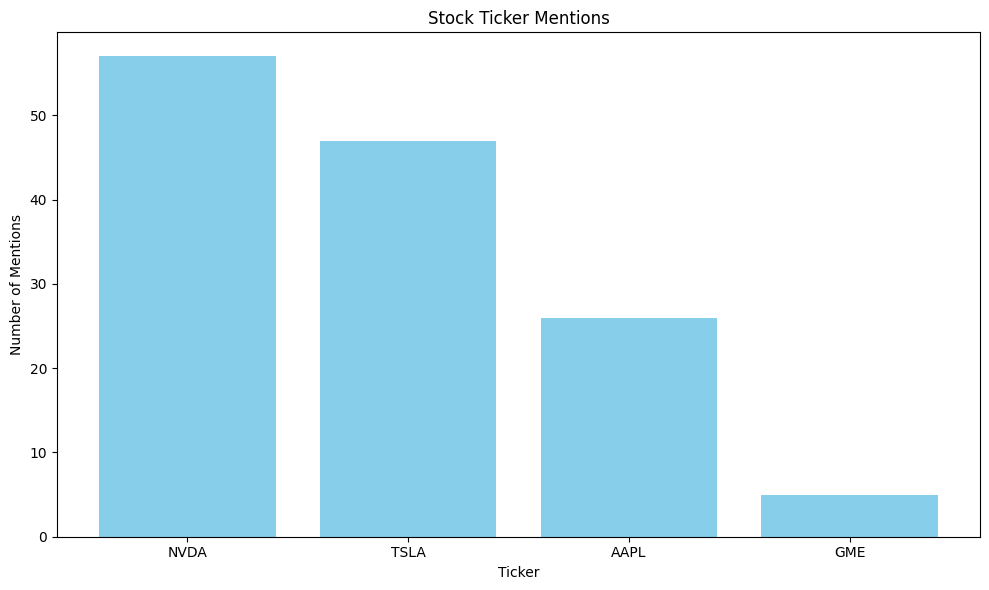

In [51]:
# Filter posts with stock mentions
stock_posts = all_data[all_data['has_target_stock'] == 1].copy()

# Calculate average engagement for stock-related posts
stock_avg_score = stock_posts['score'].mean()
stock_avg_comments = stock_posts['num_comments'].mean()

# Calculate average engagement for non-stock posts
non_stock_posts = all_data[all_data['has_target_stock'] == 0]
non_stock_avg_score = non_stock_posts['score'].mean()
non_stock_avg_comments = non_stock_posts['num_comments'].mean()

print("\nEngagement Comparison:")
print(f"Stock-related posts average score: {stock_avg_score:.1f}")
print(f"Non-stock posts average score: {non_stock_avg_score:.1f}")
print(f"Stock-related posts average comments: {stock_avg_comments:.1f}")
print(f"Non-stock posts average comments: {non_stock_avg_comments:.1f}")

import matplotlib.pyplot as plt
    
# Create a bar chart of ticker mentions
plt.figure(figsize=(10,6))
tickers = list(ticker_counts.keys())
counts = list(ticker_counts.values())
plt.bar(tickers, counts, color='skyblue')
plt.title('Stock Ticker Mentions')
plt.xlabel('Ticker')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()